In [16]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

'''
Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

```python
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
```

Submodules assigned in this way will be registered, and will have their parameters converted too when you call to(), etc.
'''
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 10)
        # print(list(self.parameters()))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        # x = F.softmax(x, dim=1) 
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return F.softmax(self.forward(x), dim=1)
    
    def test(self, test_loader: torch.utils.data.DataLoader) -> float:
        correct = 0
        total = len(test_loader.dataset)
        with torch.no_grad():
            for images, label in tqdm(test_loader):
                y = self.forward(images.view(-1, 784))
                predicted = torch.argmax(y, dim=1)
                correct += (predicted == label).sum().item()
        return correct / total

    def train(self, 
              training_set: datasets.DatasetFolder,
              test_set: datasets.DatasetFolder,
              lr: float = 0.001, 
              epochs: int = 10) -> None:
        
        size = len(training_set)
        train_set_size = int(size * 0.9)
        validation_set_size = size - train_set_size

        training_set, validation_set = torch.utils.data.random_split(training_set, [train_set_size, validation_set_size])
        train_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        last_validity = 0
        for e in range(epochs):
            for images, label in tqdm(train_loader):
                optimizer.zero_grad()
                y = self.forward(images.view(-1, 784)) # CrossEntropy already has softmax
                loss = F.cross_entropy(y, label)
                loss.backward()
                optimizer.step()
            validity = self.test(validation_loader)
            print("[Iteration {}] Accuracy on validation set: {}".format(e+1, validity))
            if validity > last_validity:
                last_validity = validity
            else:
                break
        print("Training finished. Accuracy on test set: {}".format(self.test(test_loader)))
        torch.save(model.state_dict(), "mlp.pt")
    
    def display_layer1_weights(self):
        fig, axs = plt.subplots(50, 10, figsize=(20, 100))
        for r in range(50):
            for c in range(10):
                axs[r, c].imshow(self.layer1.weight[10*r + c].view(28, 28).detach().numpy())
        fig.savefig("layer1_weights.png")

model = MLP()
try:
    print("Loading saved model")
    model.load_state_dict(torch.load("mlp.pt"))
except:
    print("No saved model found, training from scratch")
    model.train(mnist_train, mnist_test)

Loading saved model
No saved model found, training from scratch


100%|██████████| 60/60 [00:00<00:00, 97.69it/s] 


[Iteration 1] Accuracy on validation set: 0.9465


100%|██████████| 60/60 [00:00<00:00, 97.77it/s]


[Iteration 2] Accuracy on validation set: 0.9663333333333334


100%|██████████| 60/60 [00:00<00:00, 94.20it/s]


[Iteration 3] Accuracy on validation set: 0.9728333333333333


100%|██████████| 60/60 [00:00<00:00, 97.24it/s]


[Iteration 4] Accuracy on validation set: 0.9751666666666666


100%|██████████| 60/60 [00:00<00:00, 97.46it/s]


[Iteration 5] Accuracy on validation set: 0.9768333333333333


100%|██████████| 60/60 [00:00<00:00, 93.55it/s]


[Iteration 6] Accuracy on validation set: 0.9788333333333333


100%|██████████| 60/60 [00:00<00:00, 95.19it/s]


[Iteration 7] Accuracy on validation set: 0.9783333333333334


100%|██████████| 100/100 [00:01<00:00, 99.09it/s]

Training finished. Accuracy on test set: 0.9787


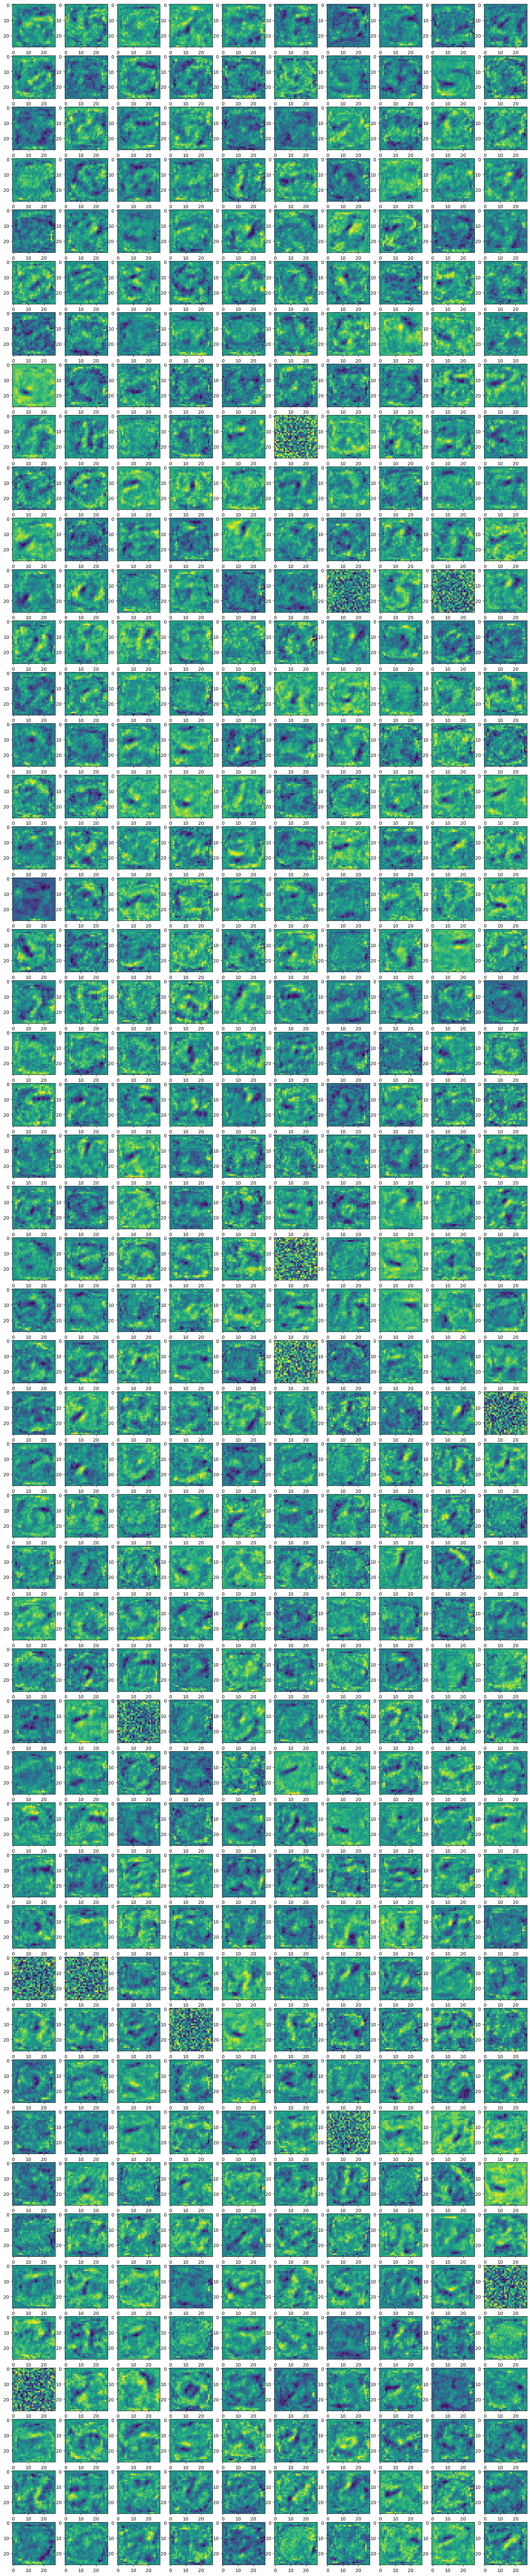

In [17]:
model.display_layer1_weights()